<a href="https://colab.research.google.com/github/yustiks/statistics_in_python/blob/master/statistics_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лекция 4. Кейс-стади. Статистические показатели.

Соревнования с kaggle: Titanic challenge. 

Данные разделены на 2 файла: 


*   тренировочные данные ('train.csv')
*   тестовые данные ('test.csv')

Тренировочные данные нужны для построения модели. Для тренировочных данных есть показатель класса для каждого пассажира. Модель будет базироваться на таких значениях как пол пассажира и класс. 

Тестовые данные нужны чтобы посмотреть насколько хорошо модель обучена на тренировочных данных. Для тестовых данных нет показателя класса. Вам необходимо найти класс для каждого пассажира. 

Есть также файл 'gender_submission.csv' как показательный файл того, что нужно загружать в качестве ответа.

Считываем данные с kaggle

In [0]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
%matplotlib inline

In [7]:
url='http://yustiks.ru/titanic/train.csv'
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Итак, есть такие данные, как:


*   PassengerId - id пассажира
*   Survived - выжил или нет (1 - да, 0 - нет)
*   Pclass - класс билеты (1 = 1ый, 2 = 2ой, 3 = 3ий)
*   Namee - имя 
*   Sex - пол 
*   Age - возраст
*   SibSp - количество родных или муж/жена на корабле
*   Parch - количество родителей/детей на корабле
*   Ticket - номер билета
*   Cabin - наименование кабины (NaN - если неизвестно)
*   Embarked - порт отправления (C = Cherbourg, Q = Queenstown, S = Southampton).

Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Начертим график плотности распределения величин. 

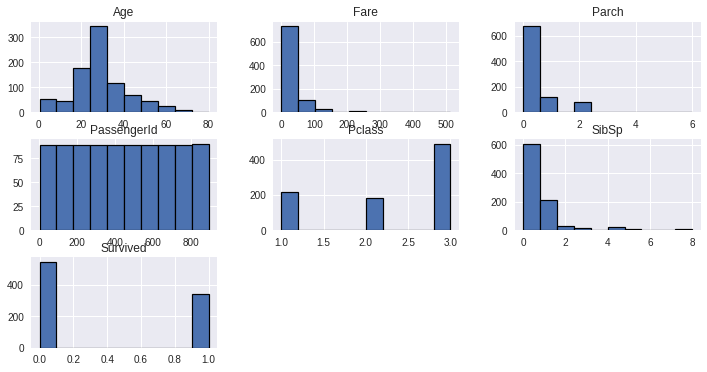

In [22]:
data.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

На графике плотностей распределения четко видны такие распределения, как 


*   Биноминальное распределение ('Survived')
*   Равномерное распределение ('PassengerId')
*   Нормальное ('Age')
*   Логнормальное ('SibSp', 'Fare')


Посмотрим отсутствующие данные:

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


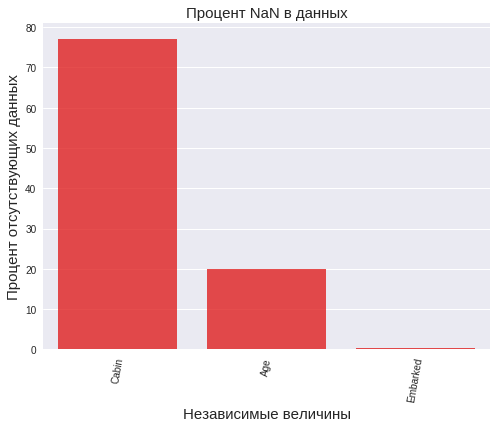

In [9]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='80')
    fig=sns.barplot(ms.index, ms["Percent"],color="red",alpha=0.8)
    plt.xlabel('Независимые величины', fontsize=15)
    plt.ylabel('Процент отсутствующих данных', fontsize=15)
    plt.title('Процент NaN в данных', fontsize=15)
    return ms

missingdata(data)

У нас есть также тестовые данные. Давайте посмотрим, отсутствуют ли в тестовых данных те же самые величины. 

In [11]:
url='http://yustiks.ru/titanic/test.csv'
s=requests.get(url).content
test=pd.read_csv(io.StringIO(s.decode('utf-8')))
print(test.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


Как можно заметить в тестовых данных нет класса Survived. 

Посмотрим процент отсутствующих данных:

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


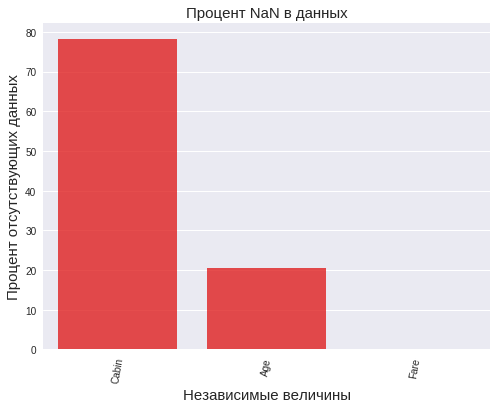

In [12]:
missingdata(test)

График очень похож на тренировочные данные, поэтому нужно придумать алгоритм, который поможет избавиться от выбросов. 

Во-первых, посмотрим график встречаемости переменной 'Age':

Text(0.5, 1.0, 'Оценка переменной')

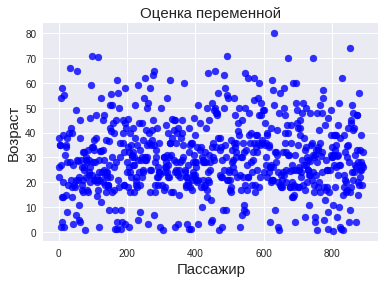

In [17]:
fig=plt.scatter(data.index, data["Age"],color="blue",alpha=0.8)
plt.xlabel('Пассажир', fontsize=15)
plt.ylabel('Возраст', fontsize=15)
plt.title('Оценка переменной', fontsize=15)

Как вариант, можно заполнить неизвестные данные по правилу медианного фильтра: вместо Nan можно использовать среднее значение (не всегда работает). 

In [0]:
test['Age'].fillna(test['Age'].median(), inplace = True)
data['Age'].fillna(data['Age'].median(), inplace = True)

То же самое делаем со значением Fare 

In [0]:
test['Fare'].fillna(test['Fare'].median(), inplace = True)

Нам не нужны значения 'Cabin', так как это просто номер кабины - удаляем колонку

In [0]:
drop_column = ['Cabin']
data.drop(drop_column, axis=1, inplace = True)
test.drop(drop_column,axis=1,inplace=True)

Значение Embarked есть отсутствующие значения в таблице тренировочных данных, но нет в тестовых, поэтому в случае с тестовыми данными мы можем например использовать наиболее встречаемое значение в качестве заполнения неизвестных (так называемую **моду** - значение признака, имеющее наибольшую частоту в статистическом ряду распределения)

In [0]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)

Проверим, имеются ли отсутствующие значения в данных

In [24]:
print(data.isnull().sum())
print(test.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Можно сказать, успешно избавились от выбросов путем заполнения данных с помощью :


*   медианы
*   моды



Объединим теперь данные в один вектор для дальнейших действий

In [0]:
all_data=[data,test]

Наверное, нам не нужны имена, но мы можем использовать такие данные, как Miss, Mister, Mademoiselle (эти данные могут говорить о происхождение человека - англичане), поэтому имеет смысл из имен вычленить только значения Miss, 

In [0]:
import re
# Библиотека re - для применения регулярных выражений
# Let us then extract second word from every row and assign it to a new column. Not only that let us make it categorical (so that we can one-hot encode it) where we observe the most frequent ones.


def title_parser(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Проверяем если значение есть, то возвращаем его, если нет, то возвращаем ''
    if title_search:
        return title_search.group(1)
    return ""
# Создаем новую колонку 'Title' для титула
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(title_parser)
# Если встречаются непонятные титулы, называем их irrelevant
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'irrelevant')
# Некоторые значения также означают Miss - Mlle, Ms, а вот Mme (Madame) означает Mrs
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Тренировочные данные

In [34]:
all_data[0][:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs


In [0]:
Тестовые данные

In [35]:
all_data[1][:4]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr


Можно увидеть, что вместе с массивом all_data поменялись значения в массиве data и test - добавилась колонка Title

In [37]:
data[:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs


In [38]:
test[:4]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr


Посмотрим как значения взаимодействуют друг с другом на графике с разбивкой на классы:

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


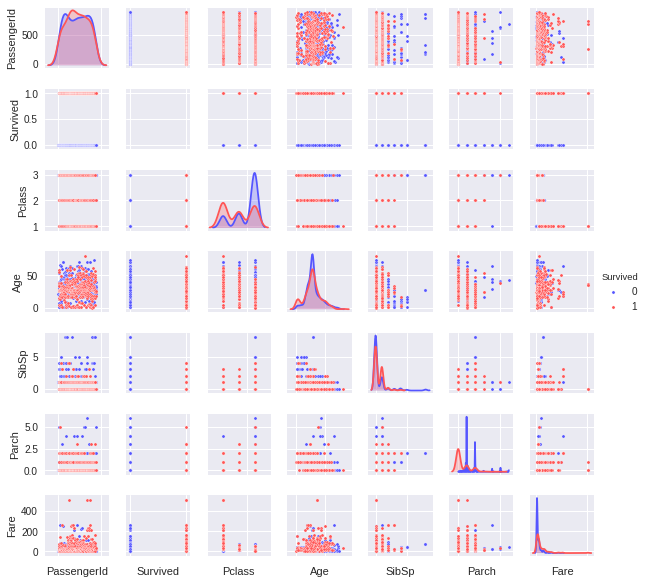

In [25]:
g = sns.pairplot(data=data, hue='Survived', palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

На основе имеющихся значений мы можем создать новые: 

In [0]:
# Создаем новое значение FamilySize как комбинацию SibSp и Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    ## создаем Age_bin для значения age 
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

# Создадим класс для fare 
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

Теперь появились новые колонки, которые также могут нести какой-то смысл (не всегда работает)

In [44]:
data[:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Age_bin,Fare_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,2,Adult,Low_fare
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,2,Adult,high_fare
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1,Adult,median_fare
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,2,Adult,high_fare


Мы можем удалить такие значения как Name и Ticket, так как из Name мы создали категорированные данные (Miss, Mister, Mrs),  а номер билета все равно ни о чем не говорит, поэтому удаляем эти колонки

In [0]:
for dataset in all_data:
    drop_column = ['Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

Проверяем: колонок стало меньше

In [47]:
data[:4]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,Age_bin,Fare_bin
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,2,Adult,Low_fare
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,2,Adult,high_fare
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,1,Adult,median_fare
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,2,Adult,high_fare


Так как у нас получилось много данных категорийных, мы можем заменить эти колонки на вектора (one-hot encoding), таким образом легче для сравнения этих значений

In [52]:
# Пример pd.dummies 
# s = pd.Series(list('abca'))
# pd.get_dummies(s)
#    a  b  c
# 0  1  0  0
# 1  0  1  0
# 2  0  0  1
# 3  1  0  0
data_new = pd.get_dummies(data, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

test_new = pd.get_dummies(test, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

data_new.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'FamilySize', 'Sex_female', 'Sex_male', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_irrelevant', 'Age_type_Children',
       'Age_type_Teenage', 'Age_type_Adult', 'Age_type_Elder', 'Em_type_C',
       'Em_type_Q', 'Em_type_S', 'Fare_type_Low_fare', 'Fare_type_median_fare',
       'Fare_type_Average_fare', 'Fare_type_high_fare'],
      dtype='object')

Получилось довольно много переменных, но насколько эти переменные имеют значение? Некоторые переменные можно исключить, так как они не несут никакой информации (сильно кореллированы с другими переменными). Нарисуем матрицу теплоты для того, чтобы показать корелляцию между переменными. Значение корелляции Пирсона в ячейках матрицы говорит о величине корелляции

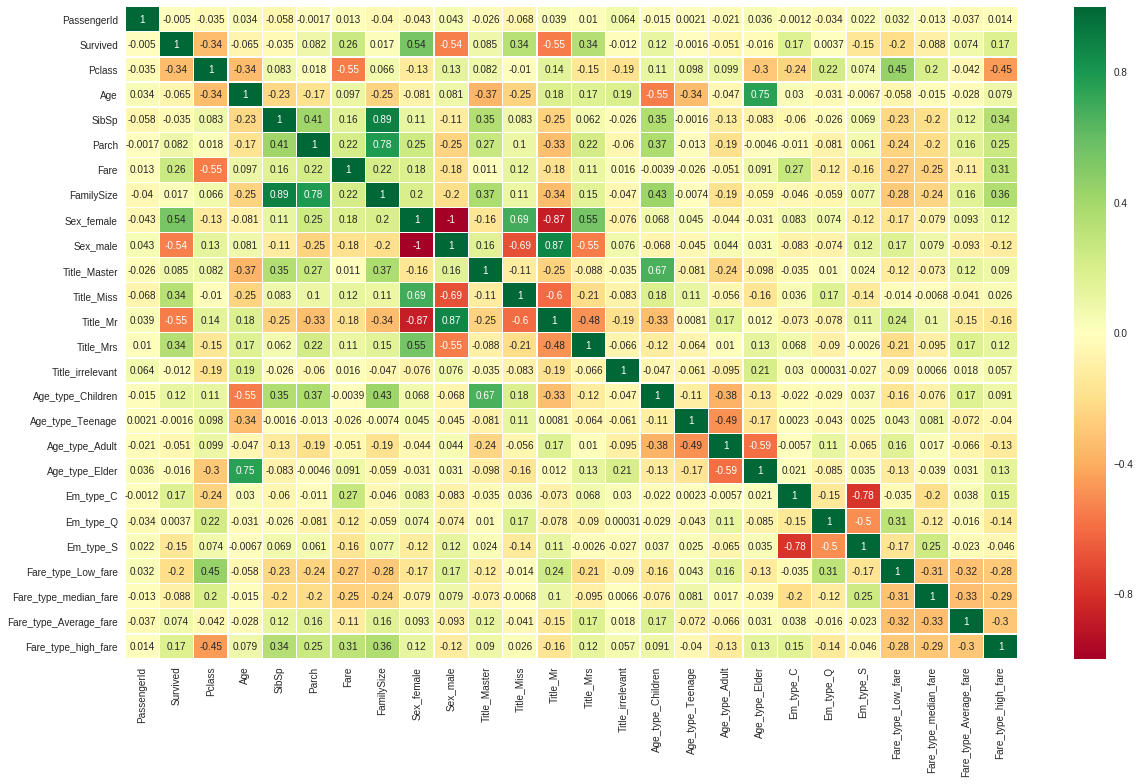

In [54]:
sns.heatmap(data_new.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

Можно например объединить такие переменные, которые имеют корелляцию больше чем 70% (красные и зеленые ячейки)

In [65]:
corr_matrix = data_new.corr().abs()

# выбирается верхний треугольник матрицы корелляций (она же симметрична)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# найдем индексы колонок с корелляцией больше чем 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print(to_drop)

['FamilySize', 'Sex_male', 'Title_Mr', 'Age_type_Elder', 'Em_type_S']


In [0]:
data_new = data_new.drop(data_new[to_drop], axis=1)
test_new = test_new.drop(test_new[to_drop], axis=1)

In [67]:
data_new[:2]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Title_Master,Title_Miss,...,Title_irrelevant,Age_type_Children,Age_type_Teenage,Age_type_Adult,Em_type_C,Em_type_Q,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,1,0,3,22.0,1,0,7.2500,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1,1,38.0,1,0,71.2833,1,0,0,...,0,0,0,1,1,0,0,0,0,1


Нормирование числовых данных

In [0]:
from sklearn.preprocessing import MinMaxScaler

# конвертируем данные Series в Numeric
data_new[['Age','Fare']] = data_new[['Age',"Fare"]].apply(pd.to_numeric)
test_new[['Age','Fare']] = test_new[['Age',"Fare"]].apply(pd.to_numeric)

In [0]:
# нормализуем данные от 0 до 1
scaler = MinMaxScaler()
data_new[['Age','Fare']] = scaler.fit_transform(data_new[['Age',"Fare"]])
test_new[['Age','Fare']] = scaler.fit_transform(test_new[['Age',"Fare"]])

In [0]:
drop_column = ['PassengerId']#удаляем id пассажира
data_new.drop(drop_column, axis=1, inplace = True)
train_X = data_new.drop("Survived", axis=1)#колонка Survived идет в новую переменную - Y output
train_Y=data_new["Survived"]
test_X  = test_new.drop("PassengerId", axis=1).copy() 

In [89]:
train_X.shape, train_Y.shape, test_X.shape

((891, 19), (891,), (418, 19))